# SingleCell Data Analysis on the CPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

sc._settings.ScanpyConfig.n_jobs = 32

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. 

In [2]:
data_load_start = time.time()

In [3]:
%%time
adata=sc.read("h5/adata.raw.h5ad")

CPU times: user 2.05 s, sys: 91.2 ms, total: 2.14 s
Wall time: 2.14 s


In [4]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 2.1470372676849365


## Preprocessing

In [5]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

Some genes will now have zero expression in all cells. We filter out such genes.

In [6]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('MT-') 

CPU times: user 4.26 ms, sys: 173 µs, total: 4.43 ms
Wall time: 4.38 ms


In [7]:
%%time
adata.var['RIBO'] = adata.var_names.str.startswith('RPS') 


CPU times: user 4.19 ms, sys: 0 ns, total: 4.19 ms
Wall time: 4.13 ms


In [8]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT','RIBO'], percent_top=None, log1p=False, inplace=True)

CPU times: user 1.3 s, sys: 48.1 ms, total: 1.35 s
Wall time: 1.35 s


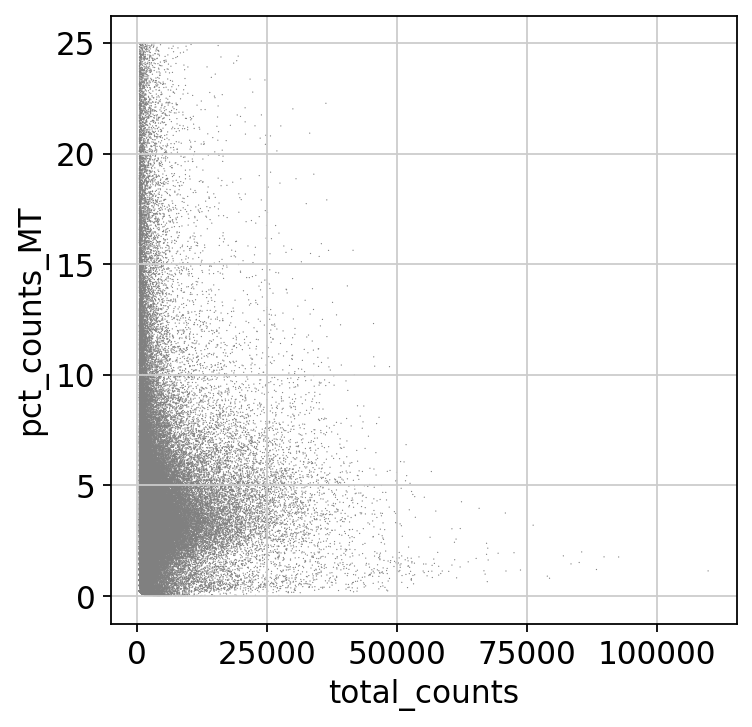

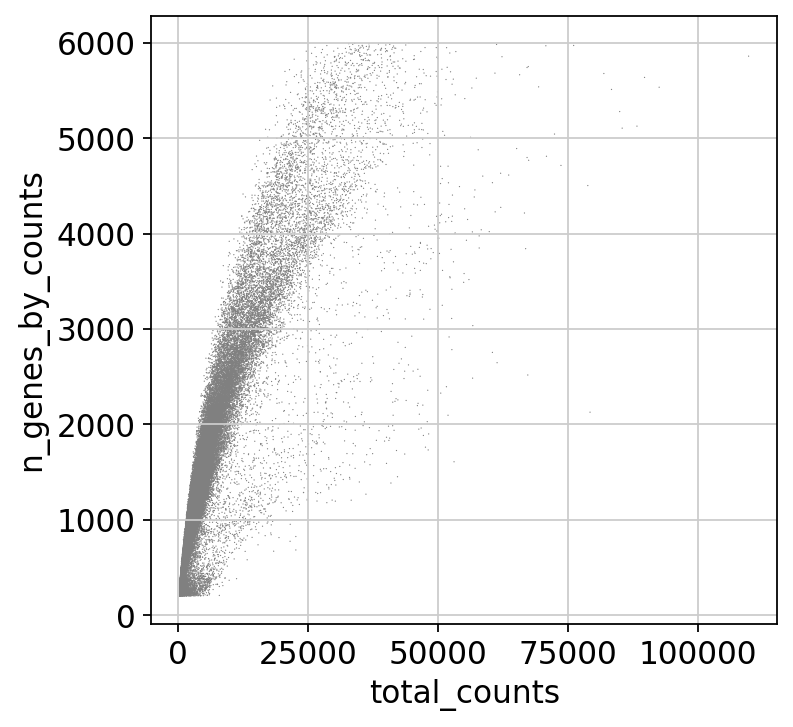

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

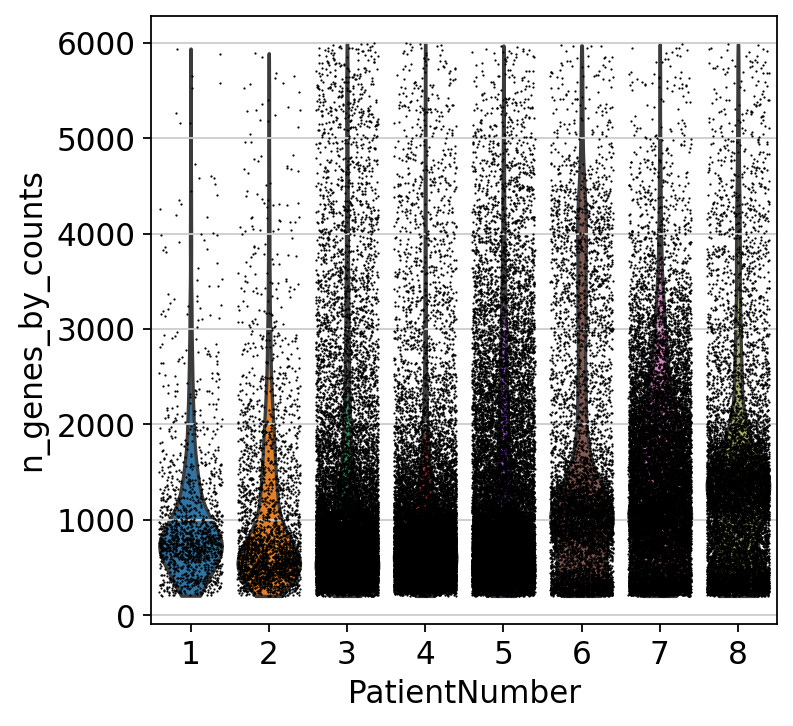

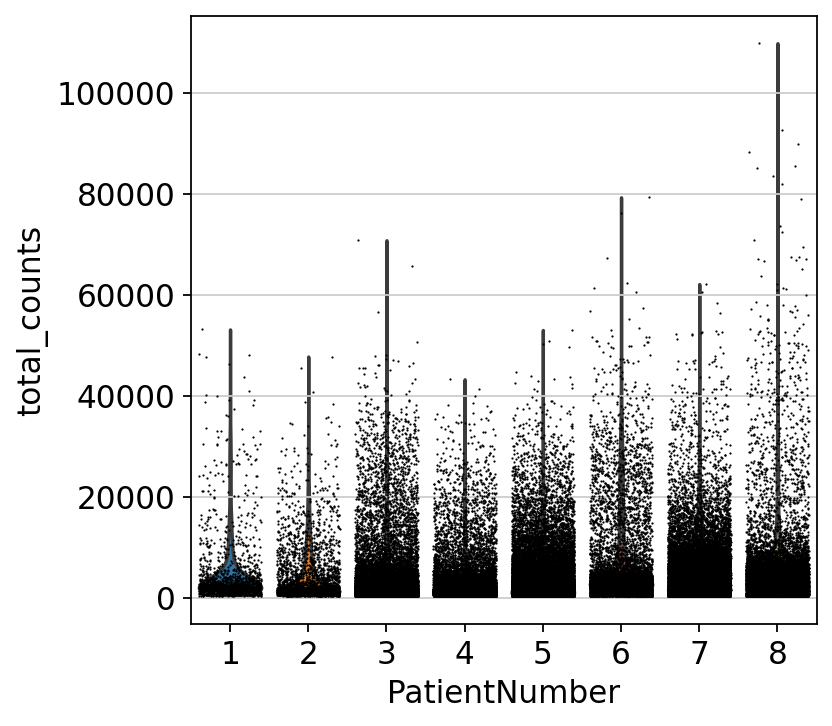

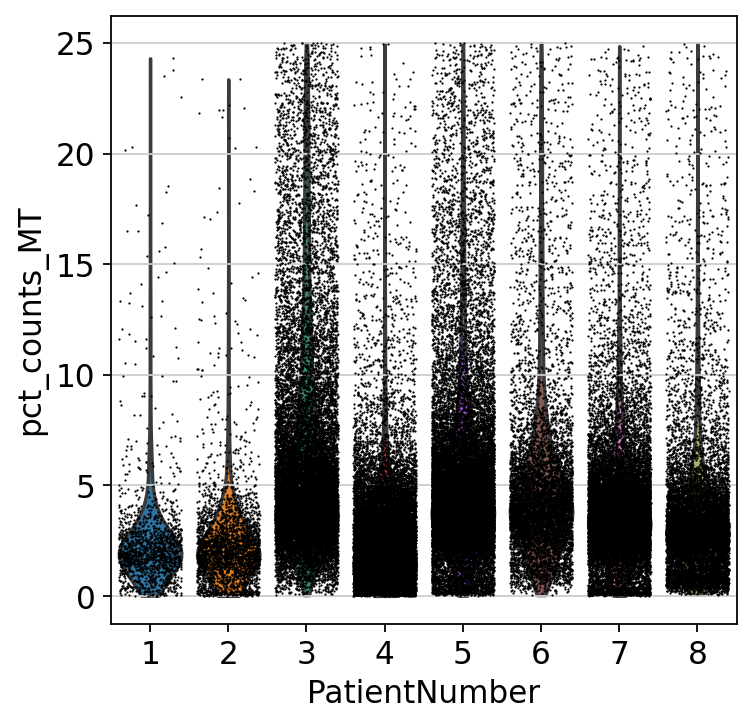

In [10]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


We store the raw expression counts in the `.layer["counts"]`

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [11]:
%%time
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata.shape

CPU times: user 7.97 ms, sys: 0 ns, total: 7.97 ms
Wall time: 7.58 ms


(92666, 33694)

In [12]:
adata = adata[adata.obs.pct_counts_MT < 20, :]
adata.shape

(91180, 33694)

Some genes will now have zero expression in all cells. We filter out such genes.

In [13]:
%%time
sc.pp.filter_genes(adata, min_cells=3)

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


CPU times: user 720 ms, sys: 253 ms, total: 973 ms
Wall time: 972 ms


In [14]:
adata.layers["counts"] = adata.X.copy()

In [15]:
adata.shape

(91180, 25365)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [16]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 245 ms, sys: 36.2 ms, total: 282 ms
Wall time: 281 ms


Next, we log transform the count matrix.

In [17]:
%%time
sc.pp.log1p(adata)

CPU times: user 785 ms, sys: 0 ns, total: 785 ms
Wall time: 784 ms


### Select Most Variable Genes

We will now select the most variable genes in the dataset.

In [18]:
%%time
sc.pp.highly_variable_genes(adata,flavor = "seurat_v3",n_top_genes=5000,batch_key="PatientNumber",layer = "counts")

CPU times: user 2.98 s, sys: 2.12 s, total: 5.1 s
Wall time: 2.72 s


Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use

In [19]:
%%time
adata.raw = adata

CPU times: user 26.2 ms, sys: 56.6 ms, total: 82.8 ms
Wall time: 81.6 ms


Restrict adata to only the highly variable genes

In [20]:
%%time
adata = adata[:, adata.var.highly_variable]

CPU times: user 48.6 ms, sys: 38.9 ms, total: 87.6 ms
Wall time: 87 ms


In [21]:
adata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. 

In [22]:
%%time
sc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 32.7 s, sys: 15.8 s, total: 48.6 s
Wall time: 1min 2s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [23]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.11 s, sys: 151 ms, total: 1.26 s
Wall time: 1.26 s


We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [24]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 72.2870683670044


## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. 

In [25]:
%%time
sc.tl.pca(adata, n_comps = 100)

CPU times: user 11min 26s, sys: 10min 28s, total: 21min 54s
Wall time: 42.3 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

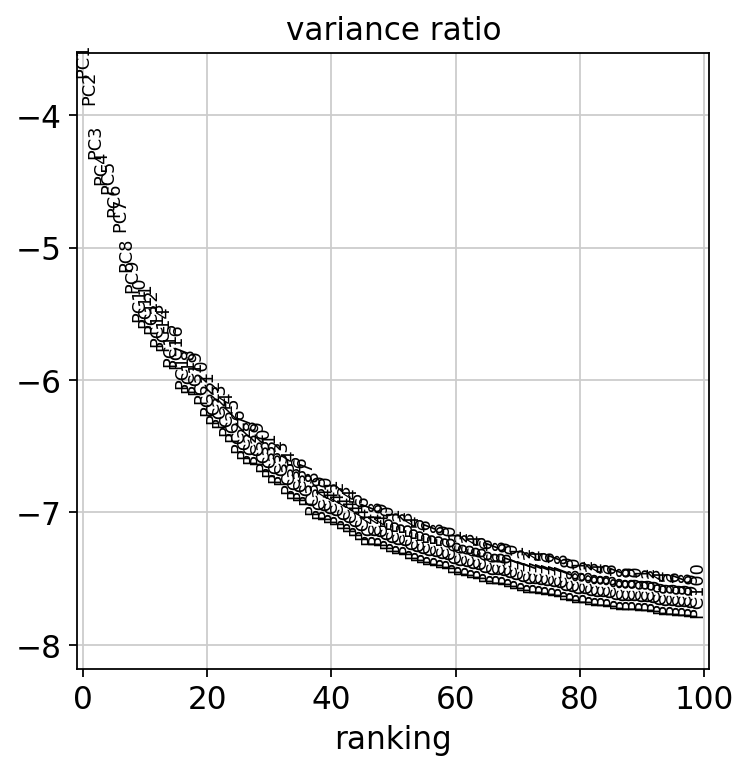

In [26]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph and UMAP

In [27]:
%%time
sc.external.pp.harmony_integrate(adata,key="PatientNumber")

2023-01-17 15:22:35,404 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-01-17 15:22:56,663 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-17 15:22:56,919 - harmonypy - INFO - Iteration 1 of 10
2023-01-17 15:23:15,038 - harmonypy - INFO - Iteration 2 of 10
2023-01-17 15:23:33,349 - harmonypy - INFO - Iteration 3 of 10
2023-01-17 15:23:51,476 - harmonypy - INFO - Iteration 4 of 10
2023-01-17 15:24:09,614 - harmonypy - INFO - Iteration 5 of 10
2023-01-17 15:24:21,397 - harmonypy - INFO - Iteration 6 of 10
2023-01-17 15:24:35,230 - harmonypy - INFO - Iteration 7 of 10
2023-01-17 15:24:53,310 - harmonypy - INFO - Iteration 8 of 10
2023-01-17 15:25:08,935 - harmonypy - INFO - Iteration 9 of 10
2023-01-17 15:25:18,762 - harmonypy - INFO - Iteration 10 of 10
2023-01-17 15:25:31,240 - harmonypy - INFO - Stopped before convergence


CPU times: user 32min 5s, sys: 56min 19s, total: 1h 28min 25s
Wall time: 2min 55s


In [28]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 26.1 s, sys: 7.74 s, total: 33.9 s
Wall time: 14.9 s


In [29]:
%%time
sc.tl.umap(adata)

CPU times: user 2min 45s, sys: 57.4 s, total: 3min 42s
Wall time: 31 s


### Clustering
We cluster the cells with the Leiden and Louvain algorithm

In [30]:
%%time
sc.tl.louvain(adata)

CPU times: user 9.27 s, sys: 80.4 ms, total: 9.35 s
Wall time: 9.33 s


In [31]:
%%time
sc.tl.leiden(adata)

CPU times: user 13.1 s, sys: 114 ms, total: 13.2 s
Wall time: 13.2 s


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


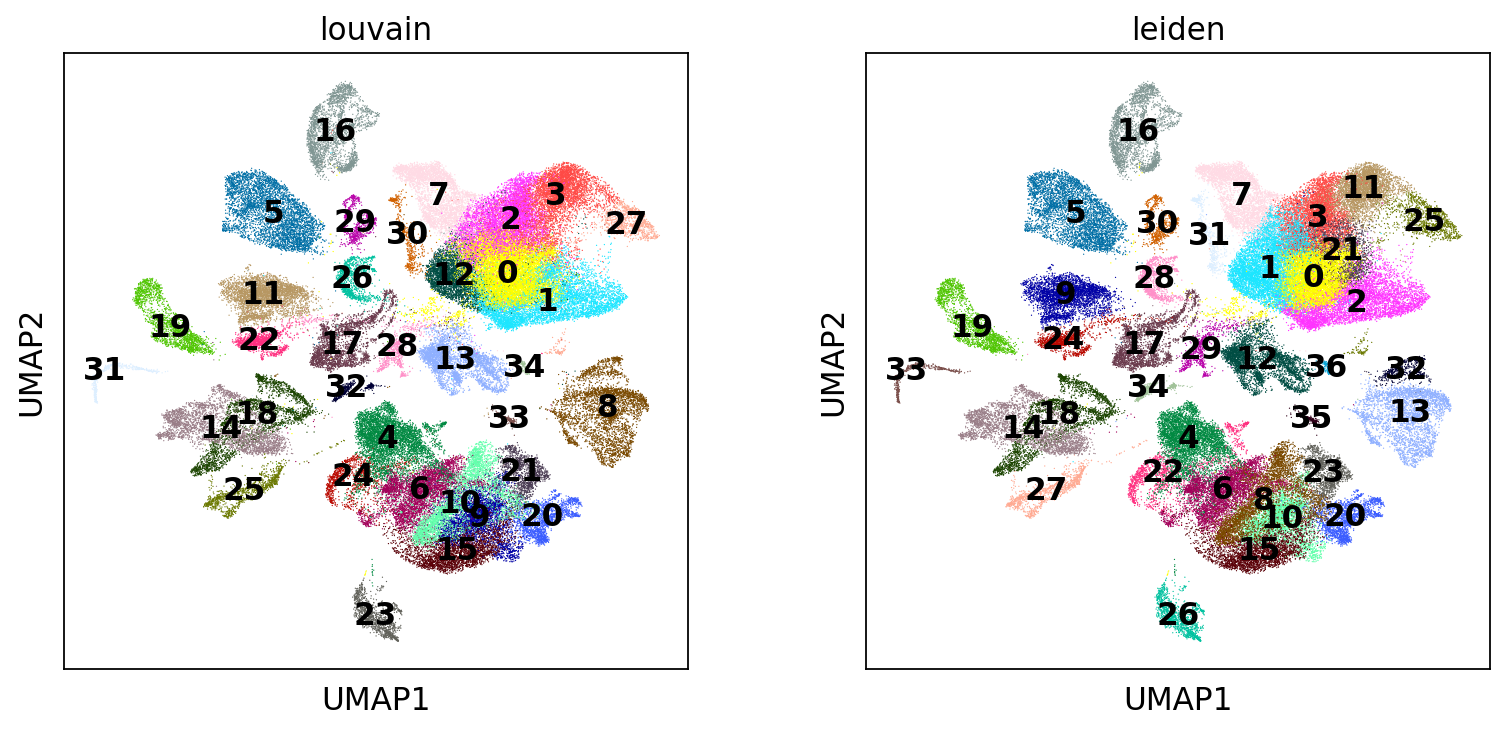

CPU times: user 600 ms, sys: 144 ms, total: 745 ms
Wall time: 585 ms


In [32]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


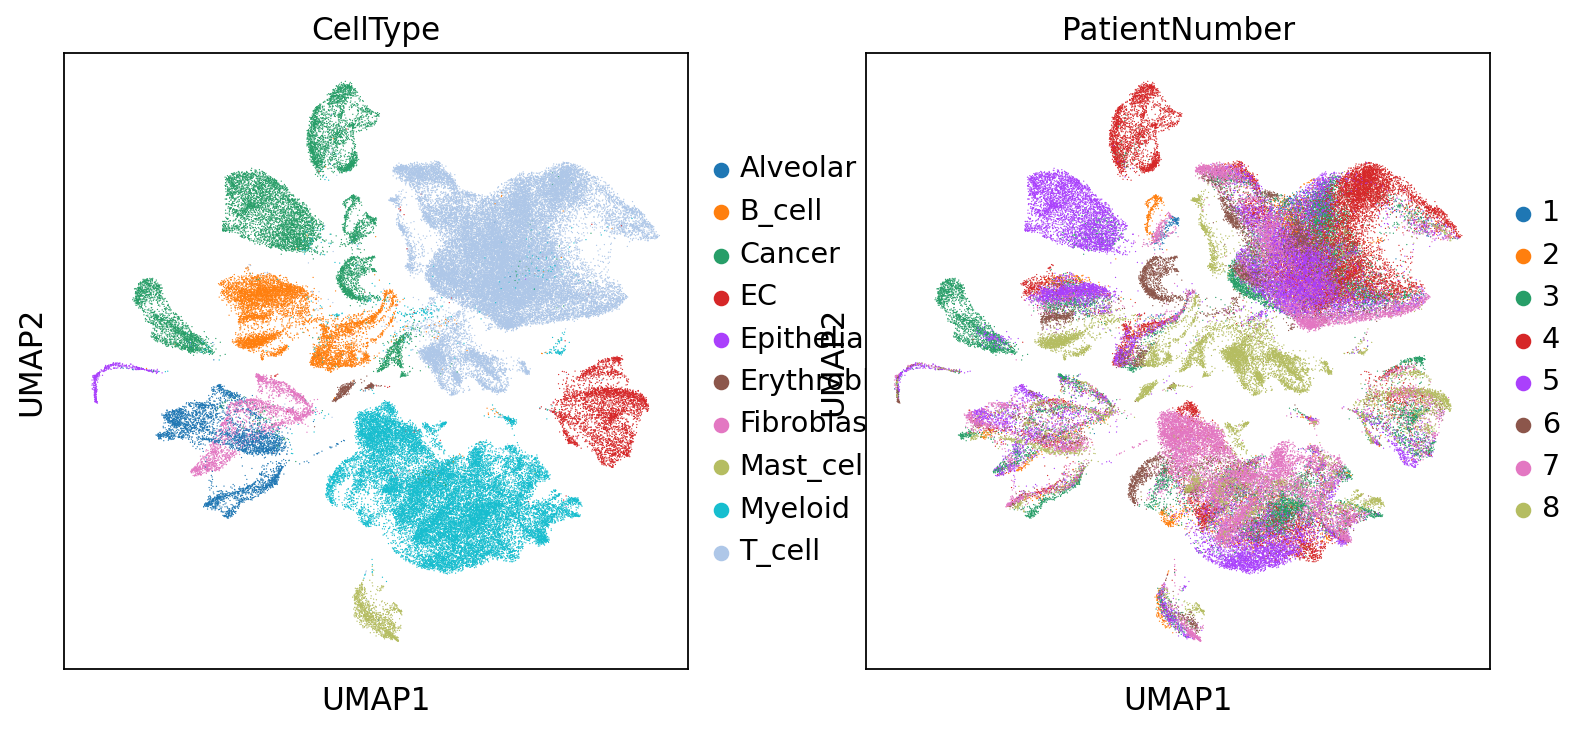

In [33]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

In [34]:
%%time
sc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 8.79 s, sys: 9.61 ms, total: 8.8 s
Wall time: 8.78 s


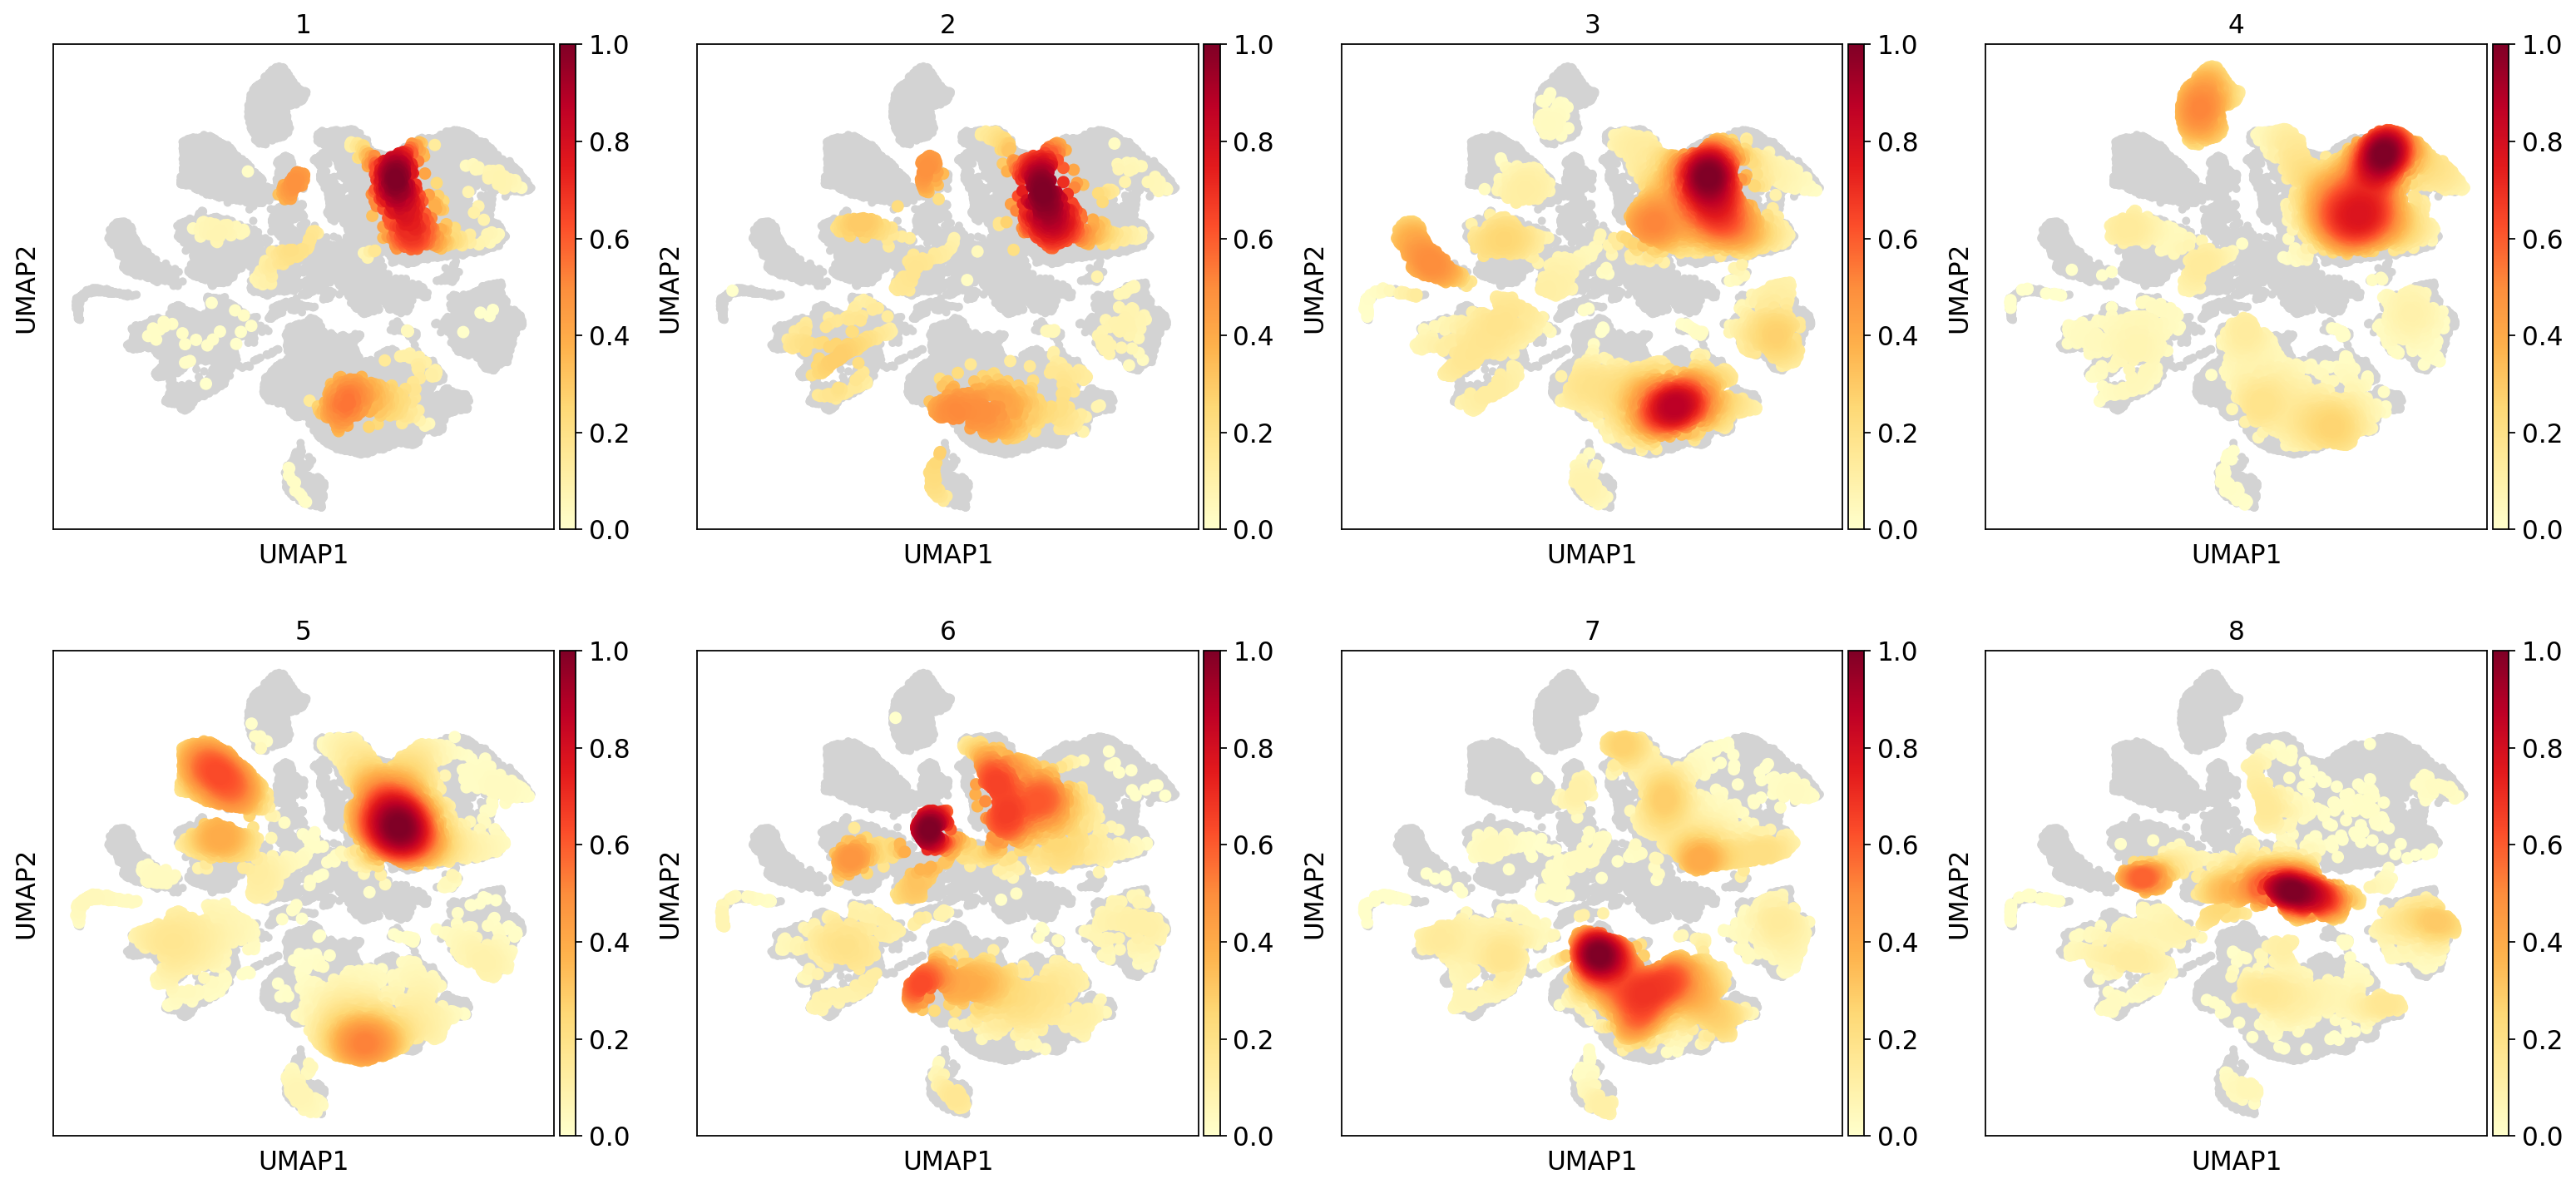

In [35]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + K-means
You might want to skip this step. Calucating a TSNE for 90000 cells takes really long 

In [36]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [37]:
%%time
sc.tl.tsne(adata, n_pcs = 40,n_jobs=-1)

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/tools/_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(


CPU times: user 20min 35s, sys: 14 s, total: 20min 49s
Wall time: 1min 35s


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


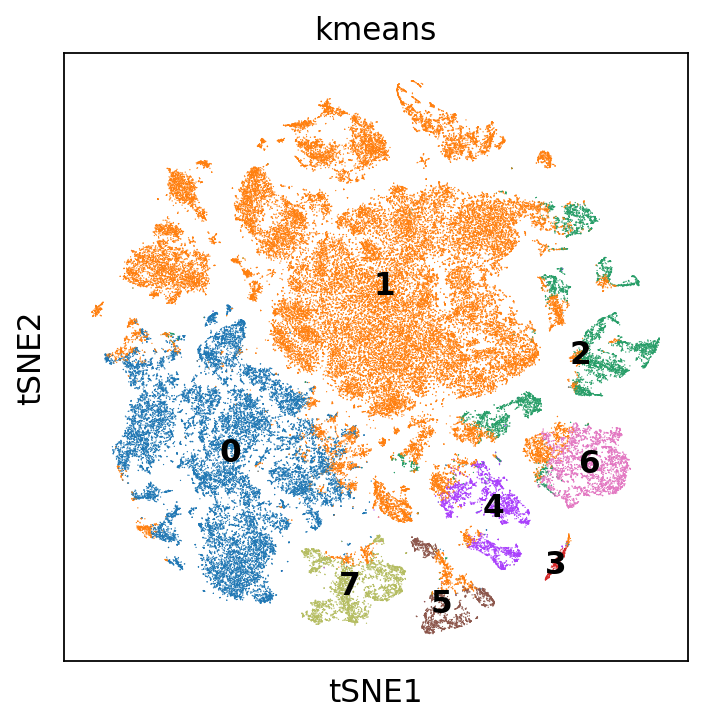

In [38]:
sc.pl.tsne(adata,color=["kmeans"], legend_loc='on data')

/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


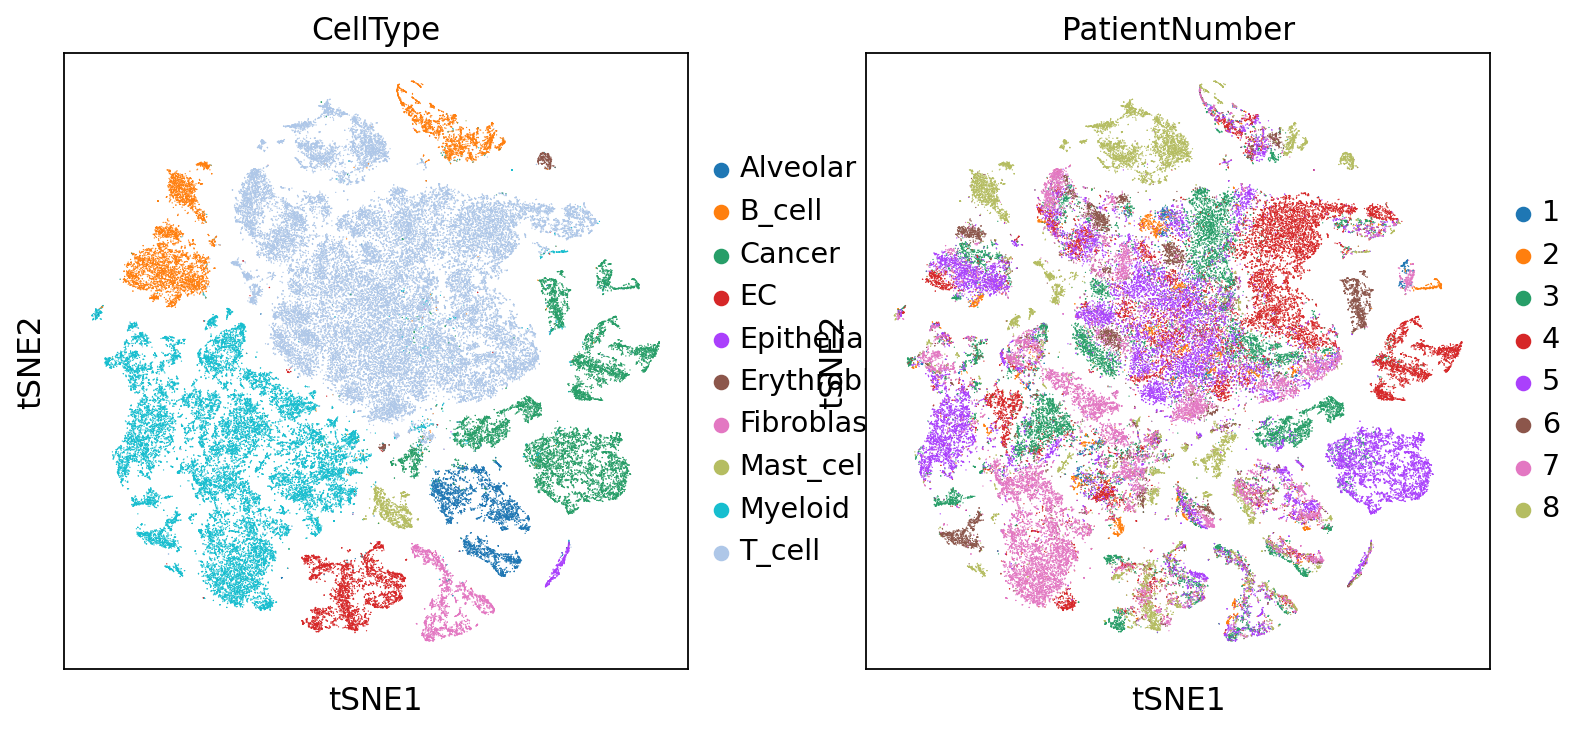

CPU times: user 737 ms, sys: 120 ms, total: 857 ms
Wall time: 698 ms


In [39]:
%%time
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

In [40]:
%%time
sc.tl.rank_genes_groups(adata, 'CellType', method='logreg', use_raw=False)

CPU times: user 29min 4s, sys: 10min 45s, total: 39min 49s
Wall time: 1min 16s


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


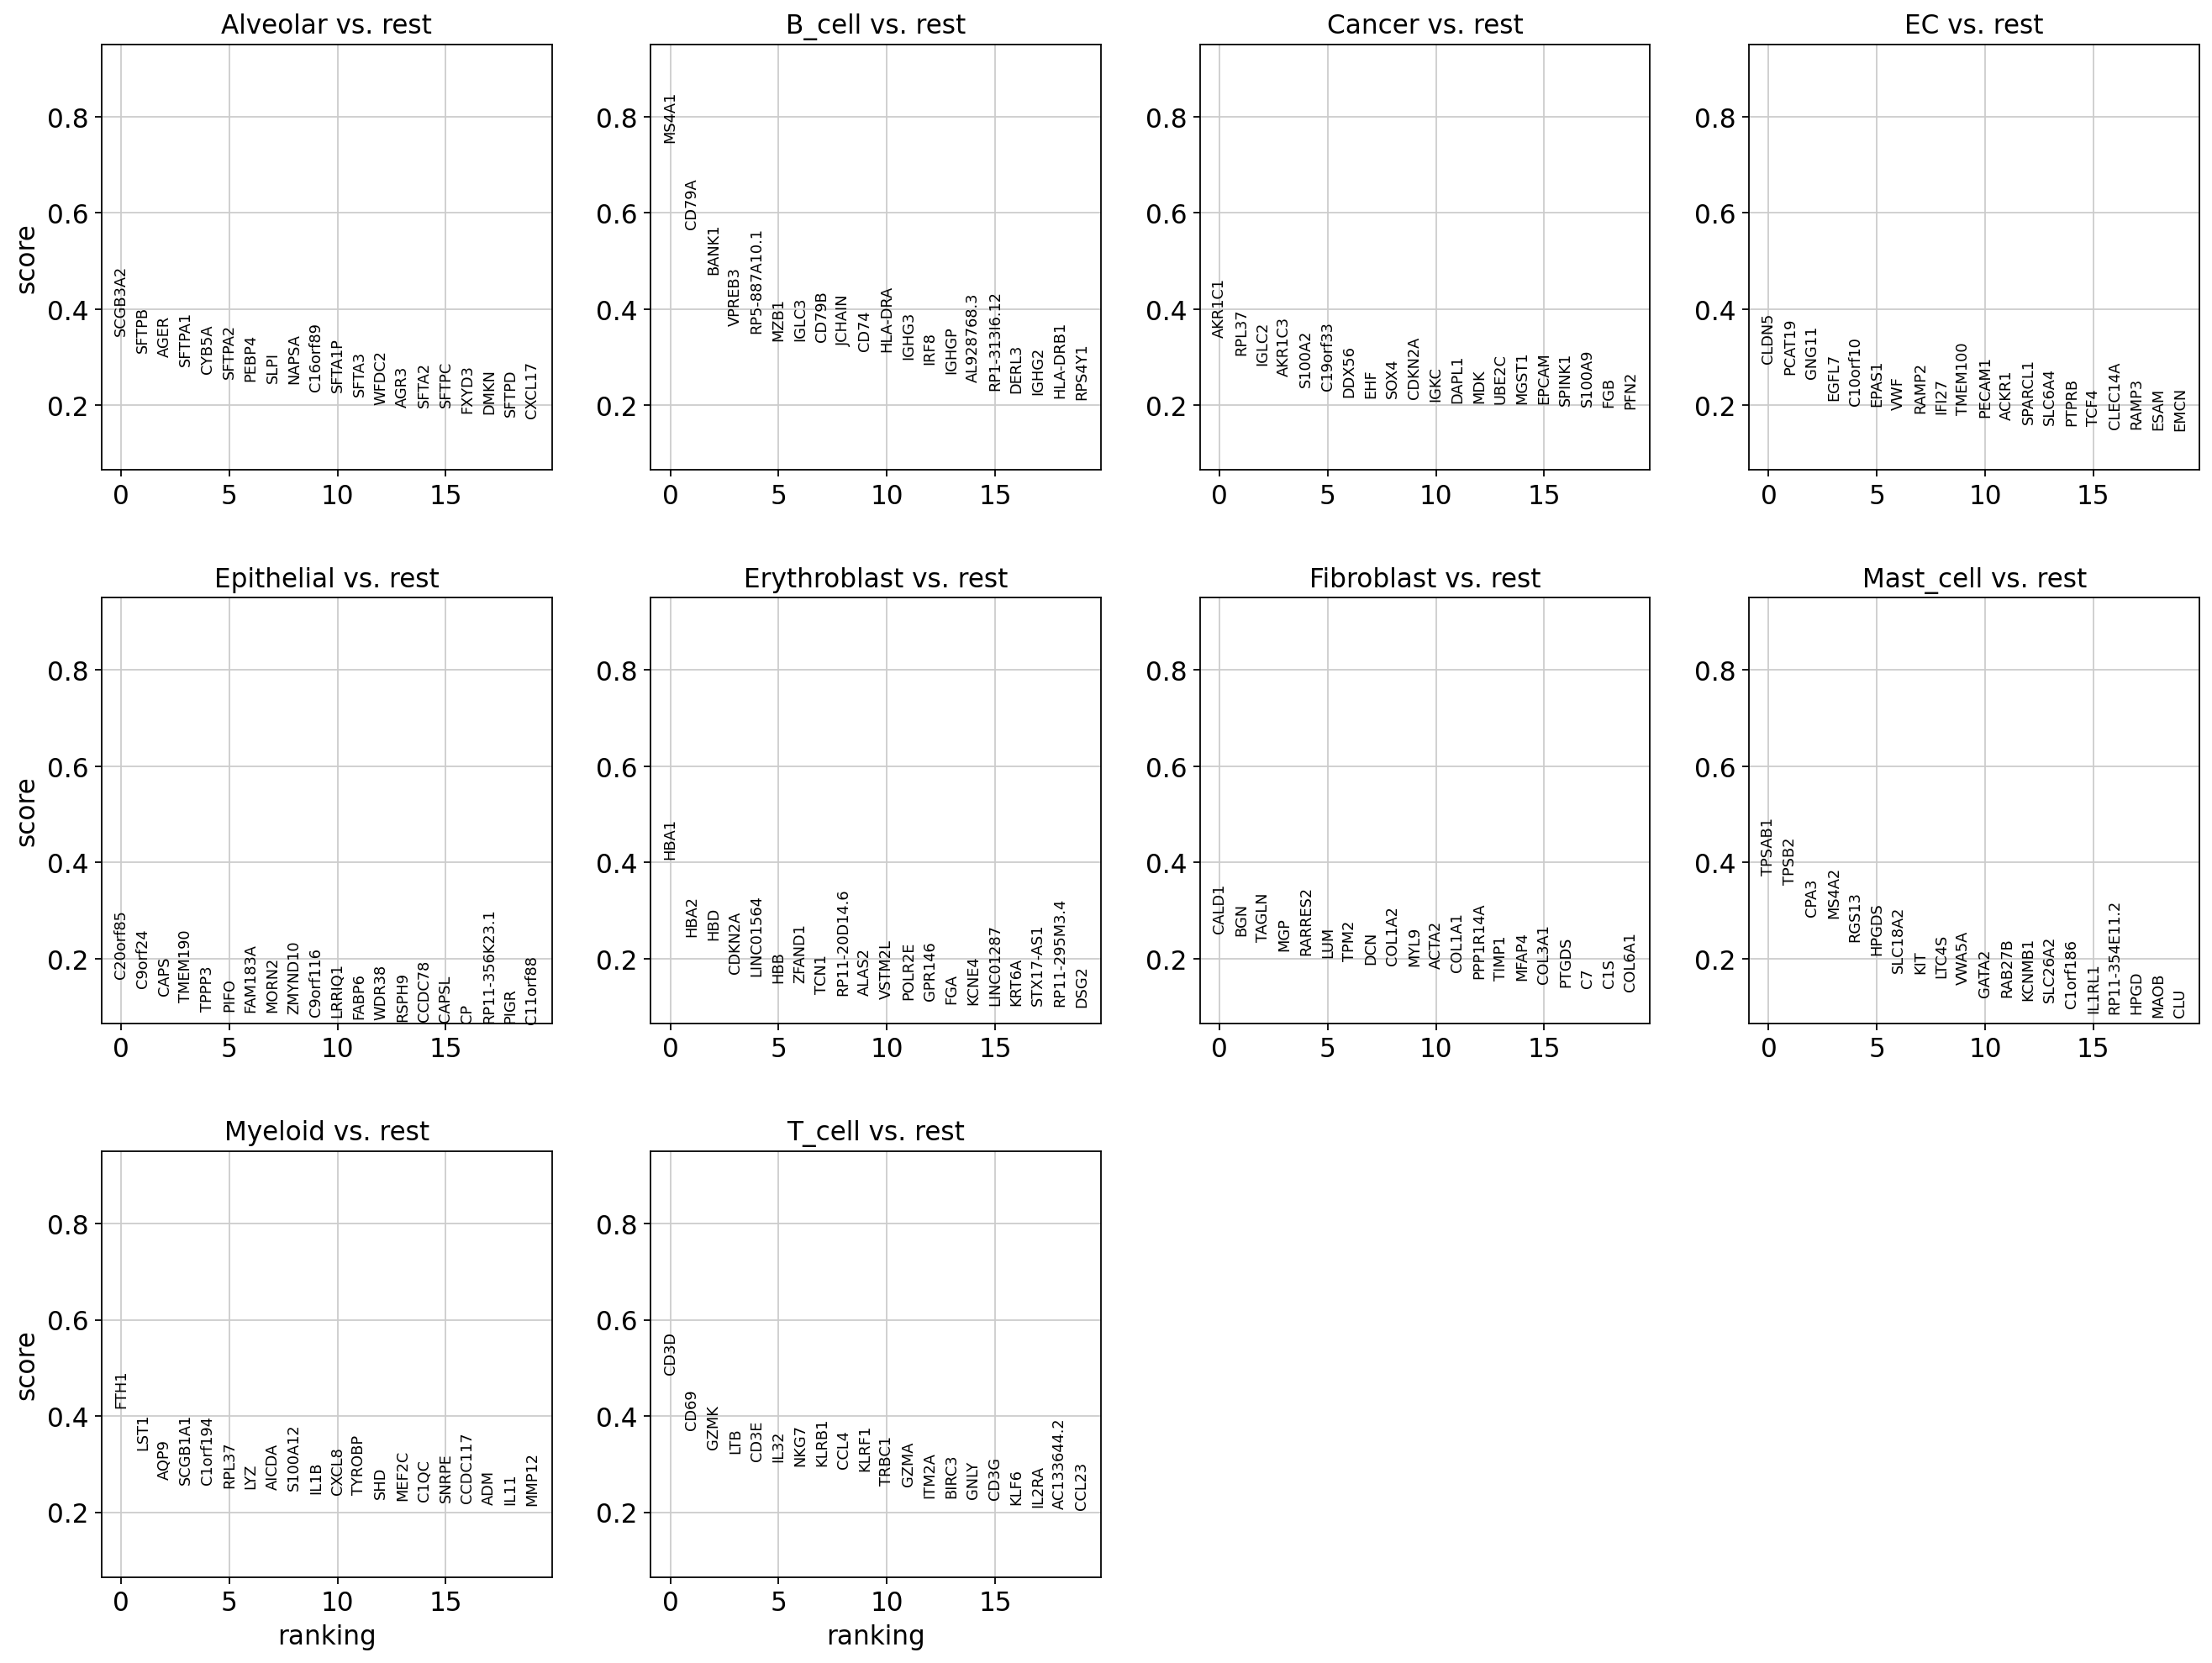

CPU times: user 940 ms, sys: 826 ms, total: 1.77 s
Wall time: 756 ms


In [41]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [42]:
post_time = time.time()

In [43]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 478.26921367645264


## Diffusion Maps

We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [44]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:]

We can repeat the dimension reduction, clustering and visulatization.

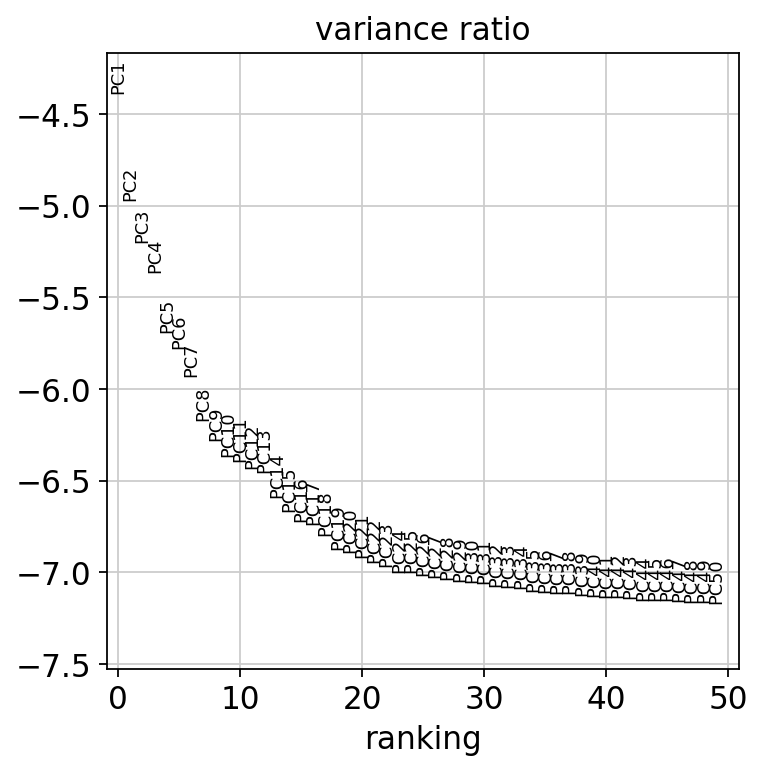

CPU times: user 4min 1s, sys: 3min 13s, total: 7min 14s
Wall time: 15 s


In [45]:
%%time
sc.pp.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [46]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
sc.tl.umap(tdata)
sc.tl.louvain(tdata)

CPU times: user 25.1 s, sys: 12.4 s, total: 37.6 s
Wall time: 15.1 s


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


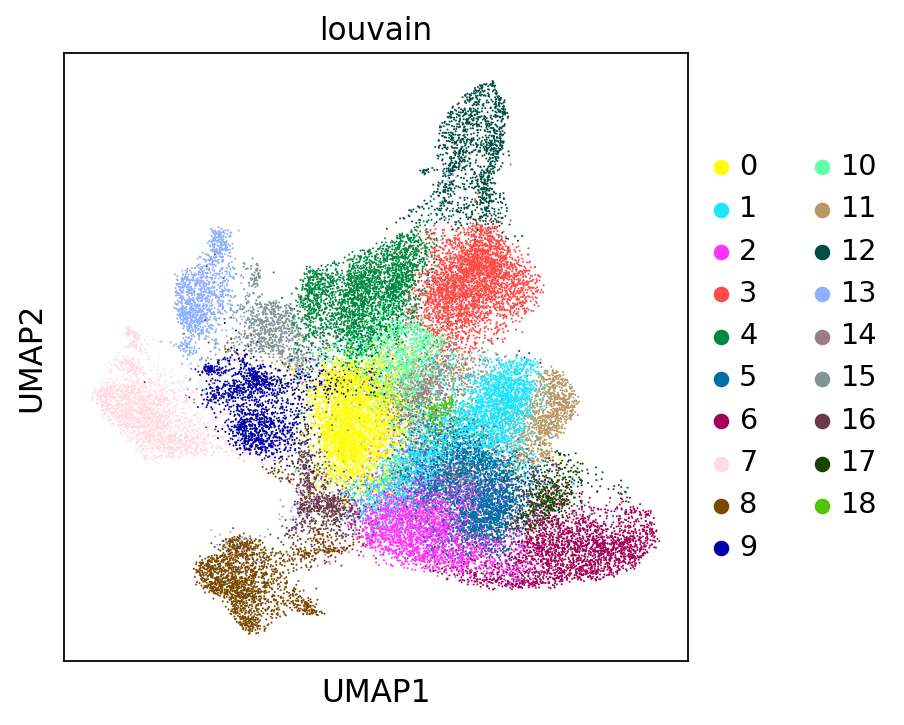

In [47]:
sc.pl.umap(tdata, color=["louvain"])

In [48]:
%%time
sc.tl.diffmap(tdata)

CPU times: user 6.79 s, sys: 13.2 s, total: 20 s
Wall time: 658 ms


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


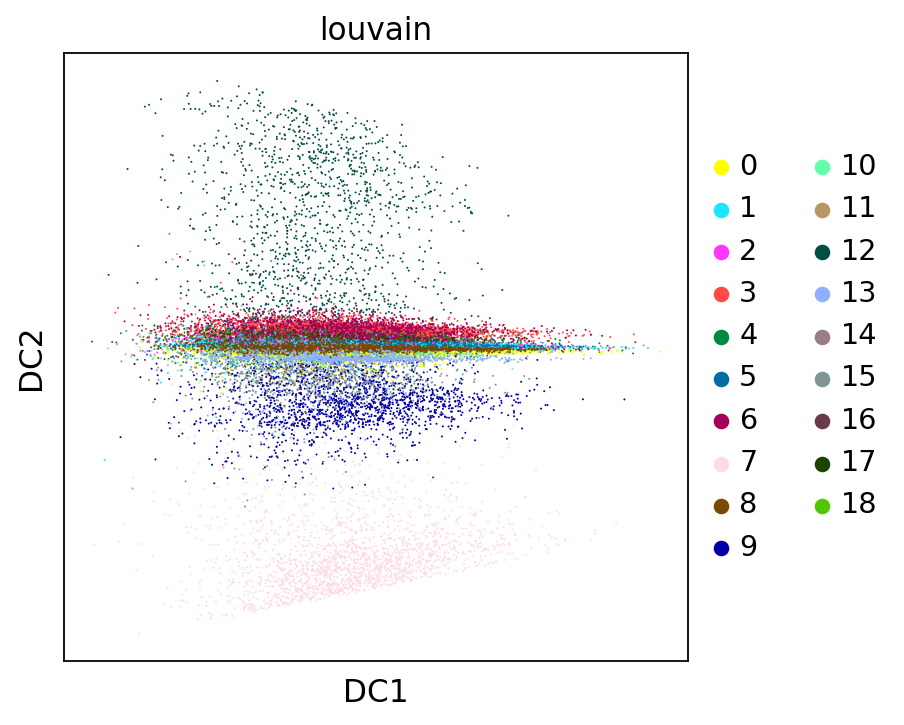

In [49]:
sc.pl.diffmap(tdata, color='louvain')

In [50]:
%%time
sc.tl.draw_graph(tdata)

CPU times: user 3min 11s, sys: 154 ms, total: 3min 11s
Wall time: 3min 11s


/home/sdicks/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


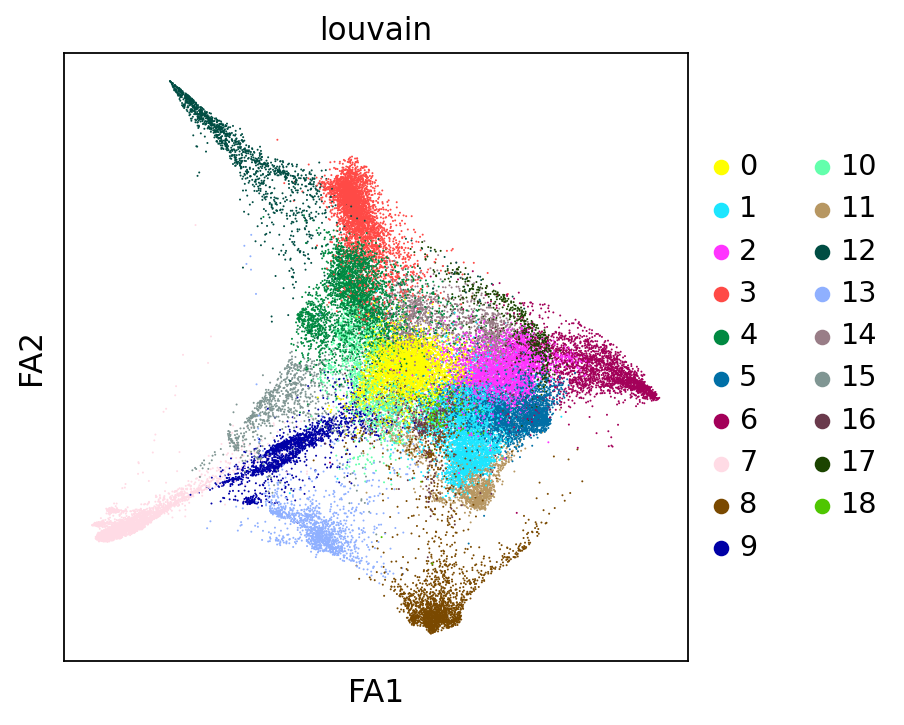

In [51]:
sc.pl.draw_graph(tdata, color='louvain')

In [52]:
print("Total Preprocessing time: %s" % (time.time()-preprocess_start))

Total Preprocessing time: 774.3784313201904
